In [11]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")


✅ Using device: cuda


In [12]:
def load_and_preprocess_data():
    # Define columns
    cols = ['unit_number', 'time_in_cycles'] + \
           [f'op_setting_{i}' for i in range(1,4)] + \
           [f'sensor_{i}' for i in range(1,22)]

    # Read and clean
    train_df = pd.read_table('train_FD004.txt', sep='\s+', header=None, names=cols)
    train_df.dropna(axis=1, inplace=True)

    # Compute RUL, clip at 125
    train_df['RUL'] = train_df.groupby('unit_number')['time_in_cycles'].transform(
        lambda x: (x.max() - x).clip(upper=125)

    )

    # Scale features
    feature_cols = [col for col in train_df.columns if col not in ['unit_number', 'time_in_cycles', 'RUL']]
    scaler = StandardScaler()
    train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])

    return train_df, scaler


In [13]:
def create_sliding_windows(df, window_size=30):
    features = [col for col in df.columns if col not in ['unit_number', 'time_in_cycles', 'RUL']]
    windows, targets = [], []

    for unit in df['unit_number'].unique():
        unit_data = df[df['unit_number'] == unit][features].values
        unit_rul = df[df['unit_number'] == unit]['RUL'].values

        for i in range(len(unit_data) - window_size + 1):
            windows.append(unit_data[i:i+window_size])
            targets.append(unit_rul[i+window_size-1])

    return np.array(windows), np.array(targets)

In [14]:
import torch
import torch.nn as nn

class RULTimesNet(nn.Module):
    def __init__(self, input_size, d_model=64, num_layers=3, n_heads=4, dropout=0.1):
        super(RULTimesNet, self).__init__()
        self.input_proj = nn.Linear(input_size, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=128,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.output = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        # x: (batch_size, seq_len, input_size)
        x = self.input_proj(x)  # → (batch_size, seq_len, d_model)
        x = self.transformer(x)  # → (batch_size, seq_len, d_model)
        x = x.mean(dim=1)  # Global average pooling over time
        return self.output(x)


In [15]:
def train_model(train_loader, val_loader, input_size, num_epochs=30, patience=5, min_delta=0.01):
    model = RULTimesNet(input_size=input_size).to(device)  # ⬅️ Use TimesNet instead of LSTM
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Initial validation loss
    model.eval()
    best_val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            best_val_loss += criterion(outputs, yb).item()
    best_val_loss /= len(val_loader)
    best_model_state = model.state_dict().copy()

    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for xb, yb in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                outputs = model(xb)
                val_loss += criterion(outputs, yb).item()
        avg_val_loss = val_loss / len(val_loader)

        # Early Stopping
        if avg_val_loss < best_val_loss - min_delta:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            print(f"💾 New best val loss: {best_val_loss:.4f}")
        else:
            patience_counter += 1
            print(f"⏳ No improvement ({patience_counter}/{patience})")
            if patience_counter >= patience:
                print("🛑 Early stopping triggered")
                break

    # Restore best model
    model.load_state_dict(best_model_state)
    torch.save(model.state_dict(), 'best_timesnet_model.pth')  # ✅ Save with new name
    print(f"✅ Best model saved (val loss: {best_val_loss:.4f})")

    return model


In [16]:
if __name__ == "__main__":
    # Load and preprocess
    train_df, scaler = load_and_preprocess_data()
    X_windows, y_rul = create_sliding_windows(train_df, window_size=30)

    # Tensorize
    X_tensor = torch.FloatTensor(X_windows)
    y_tensor = torch.FloatTensor(y_rul).unsqueeze(1)
    dataset = TensorDataset(X_tensor, y_tensor)

    # Train/Val split
    val_size = int(0.2 * len(dataset))
    train_size = len(dataset) - val_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=128)

    # Train TimesNet
    model = train_model(train_loader, val_loader, input_size=X_windows.shape[2], num_epochs=30)
    print("✅ Training complete")


Epoch 1/30: 100%|██████████| 338/338 [00:03<00:00, 97.23it/s] 


💾 New best val loss: 516.7043


Epoch 2/30: 100%|██████████| 338/338 [00:03<00:00, 109.85it/s]


💾 New best val loss: 467.6339


Epoch 3/30: 100%|██████████| 338/338 [00:03<00:00, 108.86it/s]


💾 New best val loss: 409.0831


Epoch 4/30: 100%|██████████| 338/338 [00:03<00:00, 91.46it/s] 


⏳ No improvement (1/5)


Epoch 5/30: 100%|██████████| 338/338 [00:03<00:00, 109.72it/s]


💾 New best val loss: 381.5441


Epoch 6/30: 100%|██████████| 338/338 [00:03<00:00, 109.91it/s]


💾 New best val loss: 377.7905


Epoch 7/30: 100%|██████████| 338/338 [00:03<00:00, 96.76it/s]


💾 New best val loss: 367.7894


Epoch 8/30: 100%|██████████| 338/338 [00:03<00:00, 106.18it/s]


💾 New best val loss: 347.0648


Epoch 9/30: 100%|██████████| 338/338 [00:03<00:00, 106.64it/s]


⏳ No improvement (1/5)


Epoch 10/30: 100%|██████████| 338/338 [00:03<00:00, 108.39it/s]


💾 New best val loss: 331.8416


Epoch 11/30: 100%|██████████| 338/338 [00:03<00:00, 91.29it/s] 


💾 New best val loss: 316.9782


Epoch 12/30: 100%|██████████| 338/338 [00:03<00:00, 108.35it/s]


⏳ No improvement (1/5)


Epoch 13/30: 100%|██████████| 338/338 [00:03<00:00, 108.30it/s]


⏳ No improvement (2/5)


Epoch 14/30: 100%|██████████| 338/338 [00:03<00:00, 92.98it/s]


💾 New best val loss: 276.8538


Epoch 15/30: 100%|██████████| 338/338 [00:03<00:00, 107.19it/s]


⏳ No improvement (1/5)


Epoch 16/30: 100%|██████████| 338/338 [00:03<00:00, 106.71it/s]


💾 New best val loss: 265.7133


Epoch 17/30: 100%|██████████| 338/338 [00:03<00:00, 107.48it/s]


⏳ No improvement (1/5)


Epoch 18/30: 100%|██████████| 338/338 [00:03<00:00, 90.99it/s] 


⏳ No improvement (2/5)


Epoch 19/30: 100%|██████████| 338/338 [00:03<00:00, 108.34it/s]


💾 New best val loss: 259.1498


Epoch 20/30: 100%|██████████| 338/338 [00:03<00:00, 110.08it/s]


💾 New best val loss: 250.1537


Epoch 21/30: 100%|██████████| 338/338 [00:03<00:00, 92.71it/s]


💾 New best val loss: 242.8509


Epoch 22/30: 100%|██████████| 338/338 [00:03<00:00, 109.96it/s]


⏳ No improvement (1/5)


Epoch 23/30: 100%|██████████| 338/338 [00:03<00:00, 107.67it/s]


💾 New best val loss: 224.6742


Epoch 24/30: 100%|██████████| 338/338 [00:03<00:00, 109.13it/s]


⏳ No improvement (1/5)


Epoch 25/30: 100%|██████████| 338/338 [00:03<00:00, 94.58it/s] 


⏳ No improvement (2/5)


Epoch 26/30: 100%|██████████| 338/338 [00:03<00:00, 108.65it/s]


💾 New best val loss: 211.4855


Epoch 27/30: 100%|██████████| 338/338 [00:03<00:00, 111.33it/s]


⏳ No improvement (1/5)


Epoch 28/30: 100%|██████████| 338/338 [00:03<00:00, 91.02it/s]


💾 New best val loss: 207.1979


Epoch 29/30: 100%|██████████| 338/338 [00:03<00:00, 108.20it/s]


💾 New best val loss: 194.2946


Epoch 30/30: 100%|██████████| 338/338 [00:03<00:00, 111.67it/s]


💾 New best val loss: 183.4186
✅ Best model saved (val loss: 183.4186)
✅ Training complete


In [17]:
def load_test_data():
    # Load test data
    cols = ['unit_number', 'time_in_cycles'] + \
           [f'op_setting_{i}' for i in range(1,4)] + \
           [f'sensor_{i}' for i in range(1,22)]

    test_df = pd.read_table('test_FD004.txt', sep='\s+', header=None, names=cols)
    test_df.dropna(axis=1, inplace=True)

    # Load true RULs
    true_rul = pd.read_csv('RUL_FD004.txt', sep='\s+', header=None)[0].values
    return test_df, true_rul

In [18]:
def prepare_test_windows(test_df, scaler, window_size=30):
    features = [col for col in test_df.columns if col not in ['unit_number', 'time_in_cycles']]

    # Scale features
    test_df[features] = scaler.transform(test_df[features])

    X_test = []
    unit_ids = []

    for unit in test_df['unit_number'].unique():
        unit_data = test_df[test_df['unit_number'] == unit][features].values
        if len(unit_data) >= window_size:
            window = unit_data[-window_size:]  # last 30 cycles
        else:
            # Pad with zeros if less than window size
            pad = np.zeros((window_size - len(unit_data), len(features)))
            window = np.vstack((pad, unit_data))

        X_test.append(window)
        unit_ids.append(unit)

    return np.array(X_test), unit_ids

✅ Model loaded successfully

📊 Test Set Evaluation Results:
MAE: 22.49 cycles
RMSE: 29.70 cycles
R² Score: 0.7032


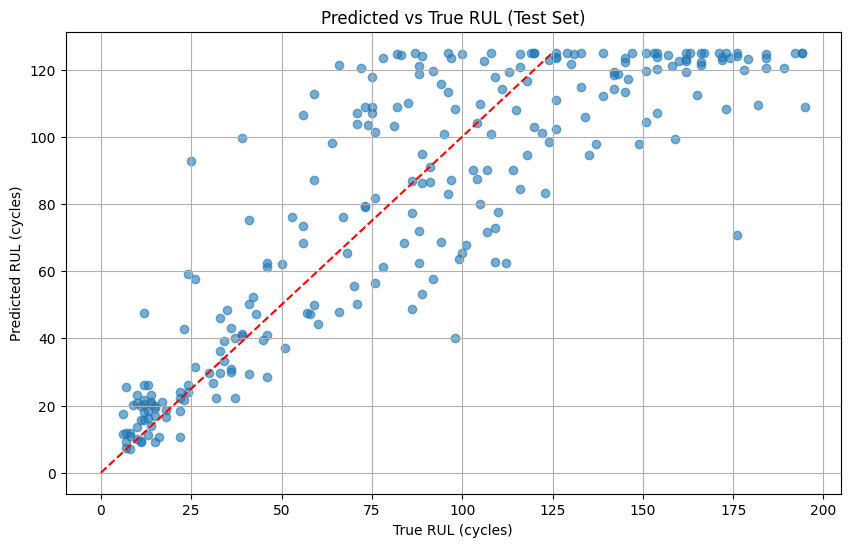

In [19]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

def evaluate_test_set(model, scaler, window_size=30):
    # 1. Load test data
    test_df, true_rul = load_test_data()

    # 2. Prepare test windows (last 30 cycles per engine)
    X_test, unit_ids = prepare_test_windows(test_df, scaler, window_size)

    # 3. Convert to tensor and predict
    X_test_tensor = torch.FloatTensor(X_test).to(device)
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor).cpu().numpy().flatten()

    # 4. Clip predictions (0-125) and calculate metrics
    predictions = np.clip(predictions, 0, 125)

    # 5. Calculate metrics
    mae = np.mean(np.abs(predictions - true_rul))
    rmse = np.sqrt(np.mean((predictions - true_rul)**2))
    r2 = r2_score(true_rul, predictions)

    # 6. Print results
    print(f"\n📊 Test Set Evaluation Results:")
    print(f"MAE: {mae:.2f} cycles")
    print(f"RMSE: {rmse:.2f} cycles")
    print(f"R² Score: {r2:.4f}")

    # 7. Plot predictions vs true RUL
    plt.figure(figsize=(10, 6))
    plt.scatter(true_rul, predictions, alpha=0.6)
    plt.plot([0, 125], [0, 125], 'r--')
    plt.xlabel('True RUL (cycles)')
    plt.ylabel('Predicted RUL (cycles)')
    plt.title('Predicted vs True RUL (Test Set)')
    plt.grid(True)
    plt.show()

    return predictions

# Usage:
# 1. Load your best saved model
model = RULTimesNet(input_size=X_windows.shape[2]).to(device)
model.load_state_dict(torch.load('best_timesnet_model.pth'))
print("✅ Model loaded successfully")

# 2. Run evaluation
test_predictions = evaluate_test_set(model, scaler)